In [2]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar

In [3]:
# List of species names to search for
species_names =  ['Panthera leo', 'Falco peregrinus', 'Oryx gazella', 'Zalophus wollebaeki', 'Rattus rattus']

# Maximum number of images to download for each species
max_images_per_species = 100

In [4]:
# Function to download and resize image
def download_and_resize_image(url, save_dir, obs_id, max_size=(256, 256)):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img.thumbnail(max_size)

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the image with a unique name based on the observation ID
        img_name = f"{obs_id}.jpg"
        img_path = os.path.join(save_dir, img_name)
        img.save(img_path)
        return img_path
    except Exception as e:
        return None

In [5]:
session = requests.Session()
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    backoff_factor=1
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount('https://', adapter)

for species_name in species_names:
    try:
        # Directory to save images for the current species, change as needed
        save_dir = f'/home/DataSet/{species_name.replace(" ", "_")}_images'

        # Fetch taxon ID for the current species name
        search_response = session.get(f'https://api.inaturalist.org/v1/taxa?q={species_name}&rank=species', timeout=10).json()
        if not search_response['results']:
            print(f"No taxon found for species: {species_name}")
            continue

        # Assume the first result is the desired species
        taxon_id = search_response['results'][0]['id']

        observation_ids = []
        image_urls = []
        common_names = []
        scientific_names = []

        valid_image_count = 0

        # Fetch observations for the current species until the desired number of images is reached
        page = 1
        while valid_image_count < max_images_per_species:
            observations_response = session.get(
                f'https://api.inaturalist.org/v1/observations?taxon_id={taxon_id}&per_page=200&page={page}', timeout=10
            ).json()
            observations = observations_response['results']

            if not observations:
                break

            for observation in tqdm(observations, desc=f'Processing observations for {species_name}'):
                if valid_image_count >= max_images_per_species:
                    break

                # Extract and store observation details
                obs_id = observation['id']
                taxon = observation.get('taxon')
                if taxon:
                    common_name = taxon.get('preferred_common_name', 'No common name available')
                    scientific_name = taxon.get('name', 'No scientific name available')
                else:
                    common_name = 'No common name available'
                    scientific_name = 'No scientific name available'

                # Extract and store image data
                if 'observation_photos' in observation and observation['observation_photos']:
                    photo = observation['observation_photos'][0]['photo']
                    image_url = photo['url']
                    image_path = download_and_resize_image(image_url, save_dir=save_dir, obs_id=obs_id)
                    if image_path:
                        observation_ids.append(obs_id)
                        common_names.append(common_name)
                        scientific_names.append(scientific_name)
                        image_urls.append(image_url)
                        valid_image_count += 1

            page += 1

        # Create a DataFrame with observation details for the current species
        data = {
            'Observation ID': observation_ids,
            'Common Name': common_names,
            'Scientific Name': scientific_names,
            'Image URL': image_urls,
            'Image Path': [os.path.join(save_dir, f"{obs_id}.jpg") for obs_id in observation_ids]
        }
        df = pd.DataFrame(data)

        # Cap the dataset size to match the number of images available
        if valid_image_count < max_images_per_species:
            df = df.head(valid_image_count)

        # Save to a CSV file for the current species, change as needed
        csv_path = f'/home/{species_name.replace(" ", "_")}_dataset.csv'
        df.to_csv(csv_path, index=False)

        print(f"Data saved to {csv_path} for species: {species_name}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

Processing observations for Panthera leo:  52%|█████▏    | 104/200 [00:36<00:33,  2.87it/s]


Data saved to /home/Panthera_leo_dataset.csv for species: Panthera leo


Processing observations for Falco peregrinus:  58%|█████▊    | 116/200 [00:33<00:24,  3.44it/s]


Data saved to /home/Falco_peregrinus_dataset.csv for species: Falco peregrinus


Processing observations for Oryx gazella:  50%|█████     | 101/200 [00:32<00:31,  3.12it/s]


Data saved to /home/Oryx_gazella_dataset.csv for species: Oryx gazella


Processing observations for Zalophus wollebaeki:  50%|█████     | 101/200 [00:34<00:33,  2.92it/s]


Data saved to /home/Zalophus_wollebaeki_dataset.csv for species: Zalophus wollebaeki


Processing observations for Rattus rattus:  50%|█████     | 100/200 [00:30<00:30,  3.25it/s]

Data saved to /home/Rattus_rattus_dataset.csv for species: Rattus rattus


In [6]:
# Count number of images downloaded
path = '/home/DataSet'
folders = os.listdir(path)
totalImages = 0
for folder in folders:
  images = os.listdir(f"{path}/{folder}")
  totalImages += len(images)

print(totalImages)

500


In [7]:
# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# Only load validation set
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]

# maps dataset to split tar & json files
splitDownloads = {}

In [9]:
# download image tar file
splitDownloads[f'{SPLIT}_img'] =  tfds.download.Resource(
          url=f'{URL}/{SPLIT_FILE}.tar.gz',
          extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
      )
# download json annotation file
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)     # downloading the tar file containing validation images

{'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x7db2208ef880>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [11]:
# paths to loaded dataset

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'],f'{SPLIT_FILE}.json')

In [12]:
with epath.Path(jsonFile).open('r') as f:
      inatJson = json.load(f)

In [13]:
def format(label: str):
      # replace ' ' with '_' in a string
      return label.lower().replace(' ', '_')

# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, image_id):

      if 'annotations' in inatJson:

        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

In [14]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [15]:
# List containing the animals that user want to see/train on
animalsToRetrieve = [format(name).lower() for name in species_names]      # formated so that images can be recognised
print(animalsToRetrieve)


['panthera_leo', 'falco_peregrinus', 'oryx_gazella', 'zalophus_wollebaeki', 'rattus_rattus']


In [16]:
annotatedFiles = {}   # stores specified annotation and metadata of species

for idx, image in enumerate(inatJson['images']):

  category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
  if (superCategory in vertebrates) and (category in animalsToRetrieve):      # Checking if the species is a vertebrate and checking latin name of the animal (using category)
    field = os.path.basename(image['file_name']).split('.')[0]

    annotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }

In [17]:
print(annotatedFiles)
print(len(annotatedFiles))

{'300262a5-cf42-4296-ad50-d9d305e19a80': {'id': 2687910, 'file_id': '300262a5-cf42-4296-ad50-d9d305e19a80', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, '68def9b7-2b36-4a03-800b-e13eea5b9f57': {'id': 2690192, 'file_id': '68def9b7-2b36-4a03-800b-e13eea5b9f57', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89': {'id': 2690373, 'file_id': 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, '9ba73392-081b-4813-bc2f-11bf64bf8a7d': {'id': 2690706, 'file_id': '9ba73392-081b-4813-bc2f-11bf64bf8a7d', 'label': 'zalophus_wollebaeki', 'superCategory': 'mammals', 'imagedirectory': '04710_Animalia_Chordata_Mammalia_Carnivora_Otariidae_Zalophus_wollebaeki'

In [19]:

# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"         # specfying the file path to store the extracted images
    imgToExtract.append(imgFilePath)

  t.extractall('/home', members=imgToExtract)


KeyboardInterrupt: 

In [20]:

from PIL import Image
import os,sys

# rename all folders to match class names of the training dataset
path = '/home/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get path of each image in class folder
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      im = Image.open(item_path)
      f, e = os.path.splitext(item_path)
      imResize = im.resize((180,180))     # resizing image so that it can be read by the model
      imResize.save(item_path,'JPEG', quality=90)

Found 500 images.
Found 500 files belonging to 5 classes.
['Falco_peregrinus_images', 'Oryx_gazella_images', 'Panthera_leo_images', 'Rattus_rattus_images', 'Zalophus_wollebaeki_images']
(32, 180, 180, 3)
(32,)
Found 9 files belonging to 5 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 512)               6554112   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_

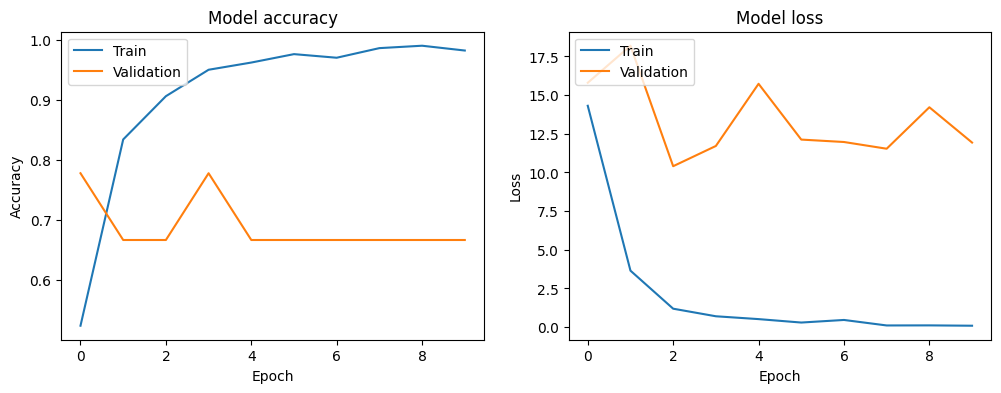

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define paths and parameters
data_dir = pathlib.Path('/home/DataSet').with_suffix('')  # Directory storing the training data
batch_size = 32
img_height = 180
img_width = 180

# Quick check on the dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Found {image_count} images.")

# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Identifying class names
class_names = train_ds.class_names
print(class_names)

# Print a batch shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/home/val',
    validation_split=None,
    subset=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Number of classes
num_classes = len(class_names)

# Load the VGG16 base model with pre-trained weights, excluding the top layers
vgg_base = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model
vgg_base.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Print model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [22]:

from PIL import Image
import os,sys


In [23]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"
    imgToExtract.append(imgFilePath)

  t.extractall('/home/val2.0', members=imgToExtract)      # download the new images to another folder

KeyboardInterrupt: 

In [24]:
# rename all folders
path = '/home/val2.0/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename folders so class folders match the names of the training dataset
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get new path to manipulate images
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    # full image path
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      print(f"Currently manipulating {item}")
      im = Image.open(item_path)

      # cropping the images to square aspect ratio
      width, height = im.size
      min_dimension = min(width, height)
      # left(x), upper(y), right(x), lower(y)
      img_mid_area = ((width - min_dimension) // 2,
                      (height - min_dimension) // 2,
                      ((width - min_dimension) // 2) + min_dimension,
                       ((height - min_dimension) // 2) + min_dimension)
      img_cropped = im.crop(img_mid_area)

      # resize square cropped images to 180x180px
      imResize = img_cropped.resize((180,180))

      imResize.save(item_path,'JPEG', quality=90)

FileNotFoundError: [Errno 2] No such file or directory: '/home/val2.0/val'

In [25]:
vgg_base = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

NameError: name 'data_augmentation' is not defined

<Figure size 1000x1000 with 0 Axes>